<a href="https://colab.research.google.com/github/Romasha-Guin/Academic-Projects/blob/main/DARNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [25]:
# Define the Input Attention Encoder Module
class InputAttentionEncoder(nn.Module):
    def __init__(self, num_series, lstm_units, time_steps, stateful=False):
        super(InputAttentionEncoder, self).__init__()
        self.num_series = num_series
        self.lstm_units = lstm_units
        self.time_steps = time_steps

        # LSTM cell for encoding
        self.encoder_lstm = nn.LSTMCell(input_size=num_series, hidden_size=lstm_units)

        # Attention matrices
        self.W_e = nn.Linear(2 * lstm_units, time_steps)
        self.U_e = nn.Linear(time_steps, time_steps, bias=False)
        self.v_e = nn.Linear(time_steps, 1, bias=False)

    def forward(self, inputs):
        encoded_inputs = torch.zeros((inputs.size(0), self.time_steps, self.lstm_units))

        # Initial hidden states
        h_tm1 = torch.zeros((inputs.size(0), self.lstm_units))
        s_tm1 = torch.zeros((inputs.size(0), self.lstm_units))

        for t in range(self.time_steps):
            # Concatenate hidden states
            h_c_concat = torch.cat((h_tm1, s_tm1), dim=1)

            # Attention weights for each series k
            x = self.W_e(h_c_concat).unsqueeze_(1).repeat(1, self.num_series, 1)
            y = self.U_e(inputs.permute(0, 2, 1))
            z = torch.tanh(x + y)
            e_k_t = torch.squeeze(self.v_e(z))

            # Normalize attention weights
            alpha_k_t = F.softmax(e_k_t, dim=1)

            # Weighted inputs
            weighted_inputs = alpha_k_t * inputs[:, t, :]

            # Calculate next hidden states
            h_tm1, s_tm1 = self.encoder_lstm(weighted_inputs, (h_tm1, s_tm1))

            encoded_inputs[:, t, :] = h_tm1
        return encoded_inputs

In [26]:
# Define the Temporal Attention Decoder Module
class TemporalAttentionDecoder(nn.Module):
    def __init__(self, encoder_units, decoder_units, time_steps, stateful=False):
        super(TemporalAttentionDecoder, self).__init__()
        self.encoder_units = encoder_units
        self.decoder_units = decoder_units
        self.time_steps = time_steps

        # LSTM cell for decoding
        self.decoder_lstm = nn.LSTMCell(input_size=1, hidden_size=decoder_units)

        # Attention matrices
        self.W_d = nn.Linear(2 * decoder_units, encoder_units)
        self.U_d = nn.Linear(encoder_units, encoder_units, bias=False)
        self.v_d = nn.Linear(encoder_units, 1, bias=False)

        # Matrix for context vector calculation
        self.w_tilda = nn.Linear(encoder_units + 1, 1)

        # Output calculation matrices
        self.W_y = nn.Linear(decoder_units + encoder_units, decoder_units)
        self.v_y = nn.Linear(decoder_units, 1)

    def forward(self, encoded_inputs, y):
        # Initialize hidden states
        d_tm1 = torch.zeros((encoded_inputs.size(0), self.decoder_units))
        s_prime_tm1 = torch.zeros((encoded_inputs.size(0), self.decoder_units))

        for t in range(self.time_steps):
            # Concatenate hidden states
            d_s_prime_concat = torch.cat((d_tm1, s_prime_tm1), dim=1)

            # Temporal attention weights
            x1 = self.W_d(d_s_prime_concat).unsqueeze_(1).repeat(1, encoded_inputs.shape[1], 1)
            y1 = self.U_d(encoded_inputs)
            z1 = torch.tanh(x1 + y1)
            l_i_t = self.v_d(z1)

            # Normalized attention weights
            beta_i_t = F.softmax(l_i_t, dim=1)

            # Create context vector
            c_t = torch.sum(beta_i_t * encoded_inputs, dim=1)

            # Concatenate c_t and y_t
            y_c_concat = torch.cat((c_t, y[:, t, :]), dim=1)

            # Create y_tilda
            y_tilda_t = self.w_tilda(y_c_concat)

            # Calculate next hidden states
            d_tm1, s_prime_tm1 = self.decoder_lstm(y_tilda_t, (d_tm1, s_prime_tm1))

        # Concatenate context vector at step T and hidden state at step T
        d_c_concat = torch.cat((d_tm1, c_t), dim=1)

        # Calculate output
        y_Tp1 = self.v_y(self.W_y(d_c_concat))
        return y_Tp1

In [27]:
# Define the DARNN Model
class DARNN(nn.Module):
    def __init__(self, num_series, encoder_units, decoder_units, time_steps, stateful_encoder=False, stateful_decoder=False):
        super(DARNN, self).__init__()
        self.encoder = InputAttentionEncoder(num_series, encoder_units, time_steps, stateful_encoder)
        self.decoder = TemporalAttentionDecoder(encoder_units, decoder_units, time_steps, stateful_decoder)

    def forward(self, X_history, y_history):
        out = self.decoder(self.encoder(X_history), y_history)
        return out

In [28]:
# Load and preprocess data
data = pd.read_csv("nasdaq100_padding.csv")
data_length = len(data)
num_timesteps = 16
num_series = data.shape[1] - 1
train_length = 35100
val_length = 2730
test_length = 2730
target_column = "NDX"

In [29]:
# Data preprocessing
X = np.zeros((len(data), num_timesteps, data.shape[1] - 1))
y = np.zeros((len(data), num_timesteps, 1))

In [30]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(num_timesteps):
        X[:, j, i] = data[name].shift(num_timesteps - j - 1).fillna(method="bfill")

for j in range(num_timesteps):
    y[:, j, 0] = data[target_column].shift(num_timesteps - j - 1).fillna(method="bfill")

In [31]:
prediction_horizon = 1
target = data[target_column].shift(-prediction_horizon).fillna(method="ffill").values

In [32]:
X = X[num_timesteps:]
y = y[num_timesteps:]
target = target[num_timesteps:]

In [33]:
# Normalization and train-validation-test split
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

In [34]:
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
y_his_train_max = y_his_train.max(axis=0)
y_his_train_min = y_his_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

In [35]:
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

y_his_train = (y_his_train - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_val = (y_his_val - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_test = (y_his_test - y_his_train_min) / (y_his_train_max - y_his_train_min)

target_train = (target_train - target_train_min) / (target_train_max - target_train_min)
target_val = (target_val - target_train_min) / (target_train_max - target_train_min)
target_test = (target_test - target_train_min) / (target_train_max - target_train_min)

In [36]:
# Convert data to PyTorch tensors
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [37]:
# Initialize DARNN model
model = DARNN(X_train.shape[2], 64, 64, X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

In [38]:
# Create data loaders
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=128)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=128)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=128)

In [39]:
# Training loop
epochs = 150
loss_function = nn.MSELoss()
patience = 15
min_val_loss = float('inf')
counter = 0

Saving model...
Epoch:  0 Train Loss:  0.1818958353124731 Val Loss:  0.13154644446471
MSE:  1190.9965 MAE:  26.714256


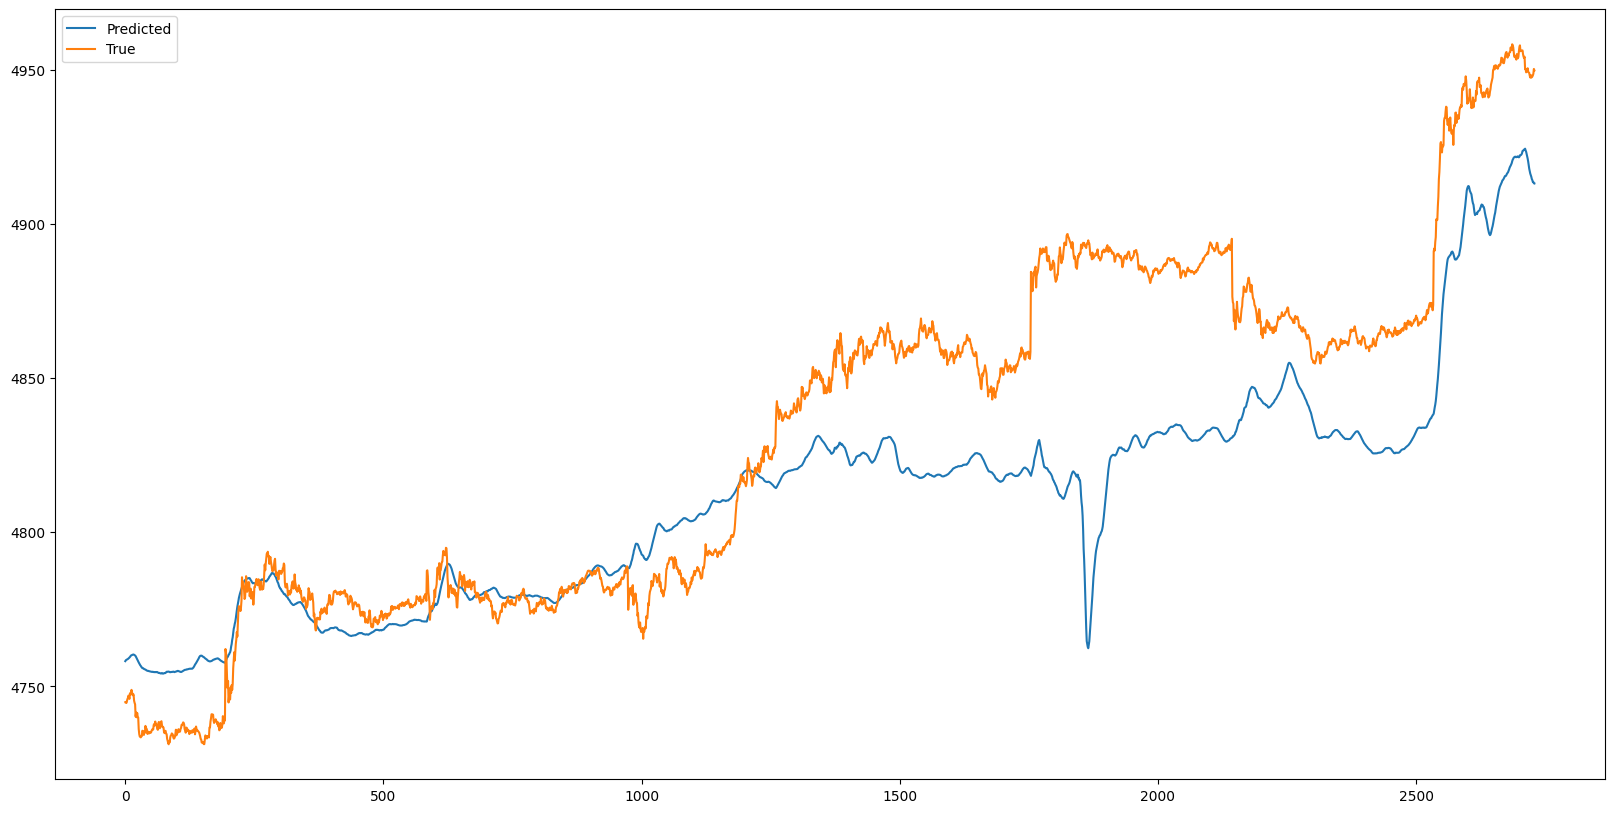

Saving model...
Epoch:  1 Train Loss:  0.032905624990810005 Val Loss:  0.06002248263877754
Saving model...
Epoch:  2 Train Loss:  0.019841349021681817 Val Loss:  0.026638012390394192
Saving model...
Epoch:  3 Train Loss:  0.017801995156892285 Val Loss:  0.022446968670826798
Epoch:  4 Train Loss:  0.01783468739826093 Val Loss:  0.025148386806818152
Saving model...
Epoch:  5 Train Loss:  0.015514064189646985 Val Loss:  0.015122808534636815
Epoch:  6 Train Loss:  0.015261628347368819 Val Loss:  0.01590820286712159
Epoch:  7 Train Loss:  0.013852167176159646 Val Loss:  0.019194092803559673
Saving model...
Epoch:  8 Train Loss:  0.013960040052049944 Val Loss:  0.013205474434933988
Saving model...
Epoch:  9 Train Loss:  0.012384209359128524 Val Loss:  0.011654310215623876
Epoch:  10 Train Loss:  0.012213191762014021 Val Loss:  0.017907945324573273
MSE:  22.072113 MAE:  3.8703933


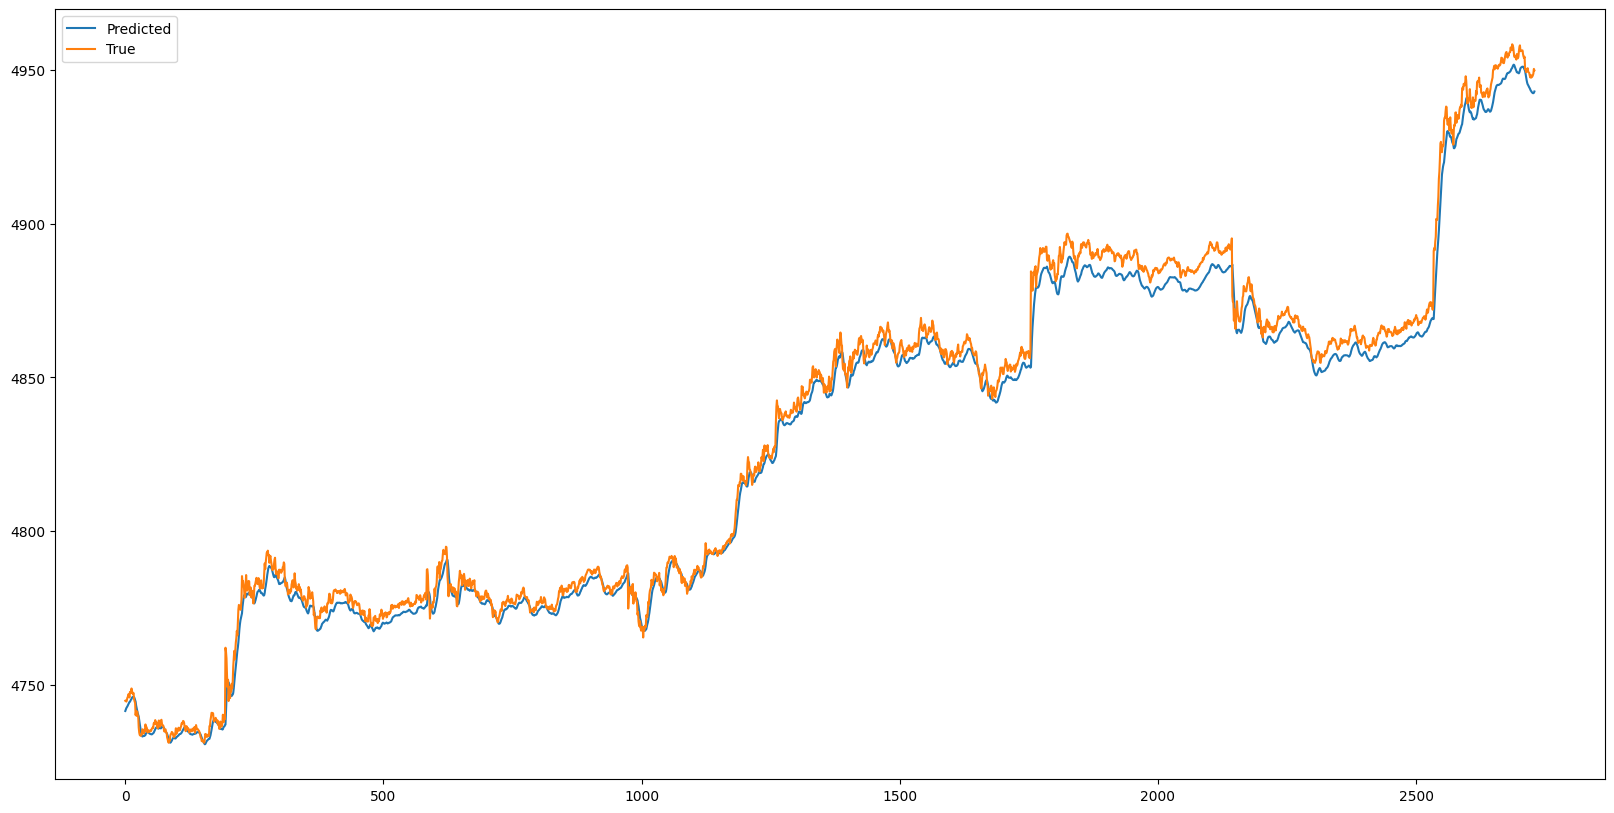

Saving model...
Epoch:  11 Train Loss:  0.011367570350067236 Val Loss:  0.010107069869960216
Saving model...
Epoch:  12 Train Loss:  0.011155218717983485 Val Loss:  0.009933973062554884
Saving model...
Epoch:  13 Train Loss:  0.010471040546046044 Val Loss:  0.009535030991140399
Epoch:  14 Train Loss:  0.010268260325153203 Val Loss:  0.009815210253985192
Saving model...
Epoch:  15 Train Loss:  0.00972611240130344 Val Loss:  0.00886757803005979
Epoch:  16 Train Loss:  0.00954696245730801 Val Loss:  0.010309218984327647
Epoch:  17 Train Loss:  0.009741349047193305 Val Loss:  0.011883824885237385
Saving model...
Epoch:  18 Train Loss:  0.009161937767403193 Val Loss:  0.008625203654822073
Epoch:  19 Train Loss:  0.009438112061032709 Val Loss:  0.014182150676660314
Saving model...
Epoch:  20 Train Loss:  0.008408593935615834 Val Loss:  0.007557530429618182
MSE:  3.9310894 MAE:  1.3085352


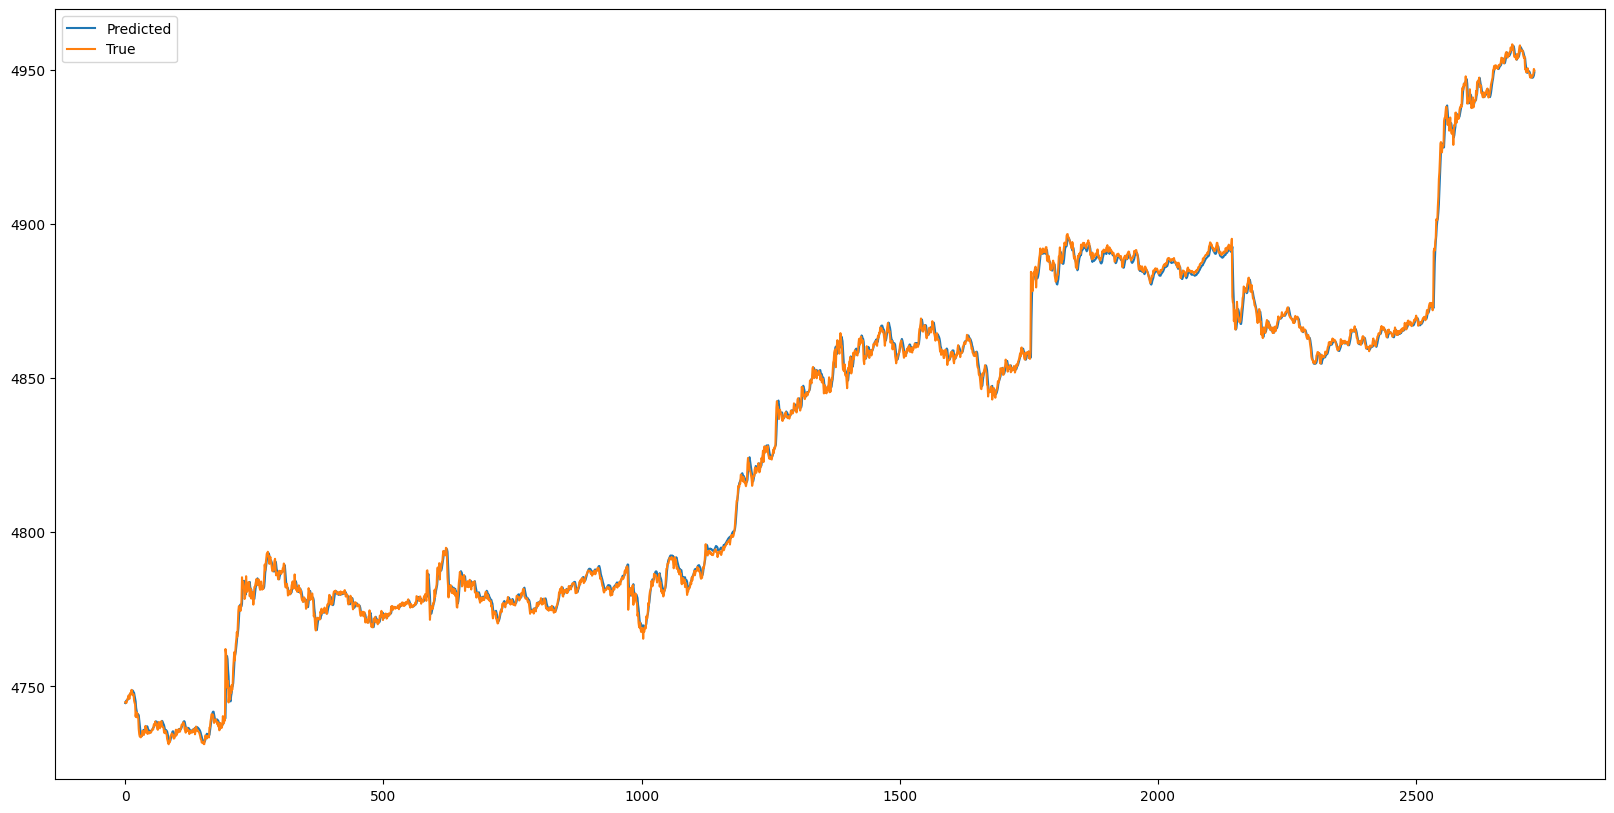

Epoch:  21 Train Loss:  0.008884250491355642 Val Loss:  0.009125396035652428
Epoch:  22 Train Loss:  0.008797545274215486 Val Loss:  0.007663178587098534
Epoch:  23 Train Loss:  0.008363003024365304 Val Loss:  0.009155176561027023
Epoch:  24 Train Loss:  0.008276051561440236 Val Loss:  0.01422176965803177
Epoch:  25 Train Loss:  0.008458976146367982 Val Loss:  0.008304263388969509
Epoch:  26 Train Loss:  0.007806211914478508 Val Loss:  0.0089692243790016
Epoch:  27 Train Loss:  0.007850115953635991 Val Loss:  0.007990953599562632
Saving model...
Epoch:  28 Train Loss:  0.007574855877462629 Val Loss:  0.007351222616353171
Epoch:  29 Train Loss:  0.007653121308706088 Val Loss:  0.009885489370576858
Epoch:  30 Train Loss:  0.007640042860241452 Val Loss:  0.007502394024059319
MSE:  3.873929 MAE:  1.3898364


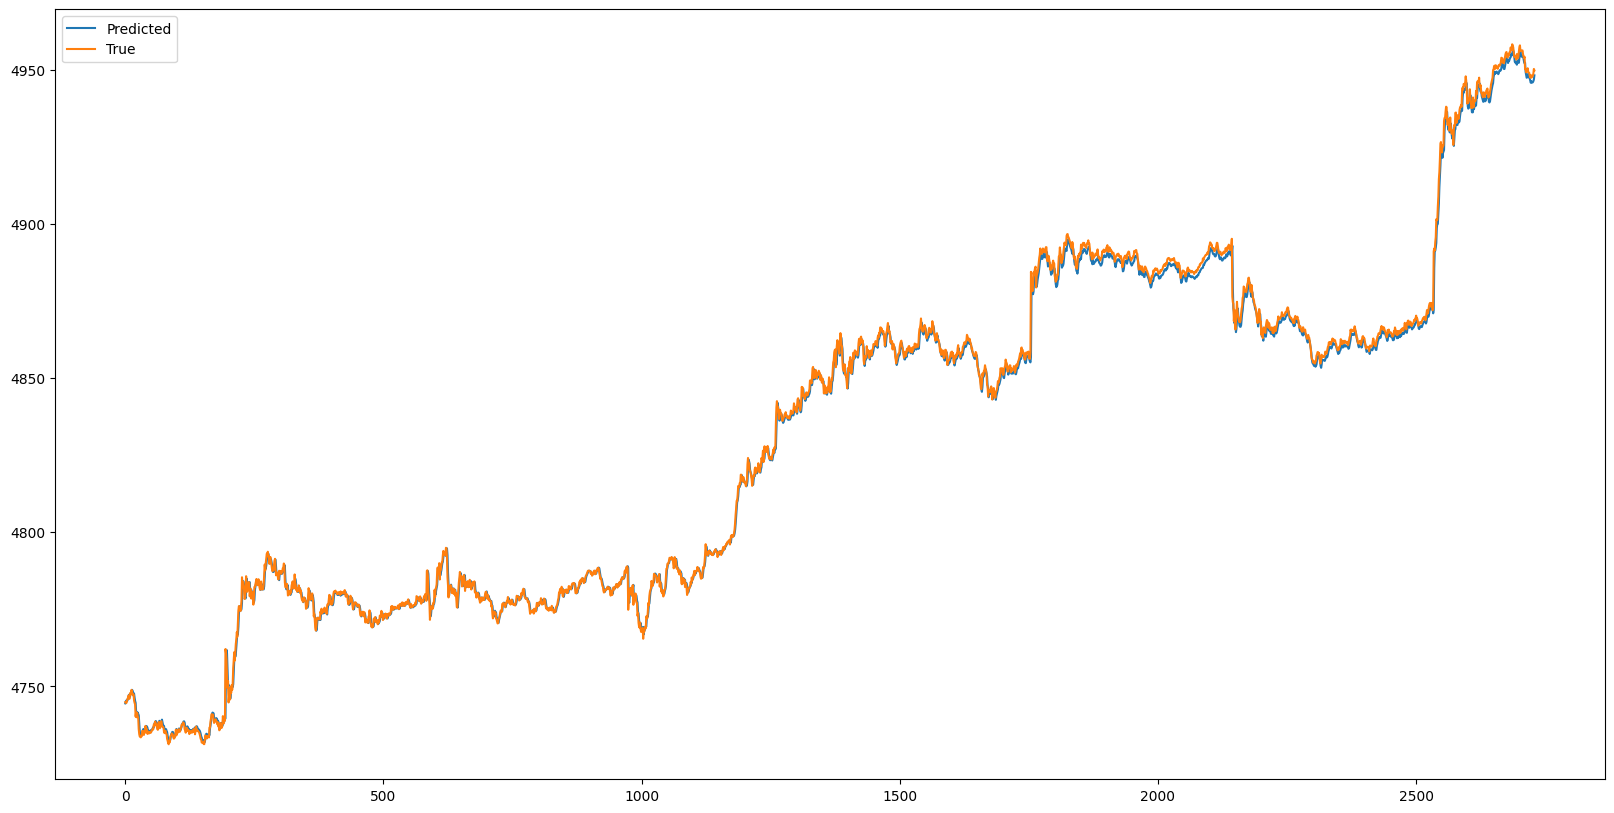

Epoch:  31 Train Loss:  0.007293579244886541 Val Loss:  0.011898121781114598
Epoch:  32 Train Loss:  0.007496461812054543 Val Loss:  0.010219460742670832
Epoch:  33 Train Loss:  0.007466471936952623 Val Loss:  0.017434847239145984
Epoch:  34 Train Loss:  0.007681220878148435 Val Loss:  0.00887492515196574
Epoch:  35 Train Loss:  0.007357201591683434 Val Loss:  0.00747432396433377
Saving model...
Epoch:  36 Train Loss:  0.007316518700516291 Val Loss:  0.007087479793166139
Saving model...
Epoch:  37 Train Loss:  0.006946606525242764 Val Loss:  0.006866250551140799
Saving model...
Epoch:  38 Train Loss:  0.006891611584978598 Val Loss:  0.006734284071263323
Saving model...
Epoch:  39 Train Loss:  0.007175717608456026 Val Loss:  0.006540404663253528
Saving model...
Epoch:  40 Train Loss:  0.0070315640883112035 Val Loss:  0.006230234431484958
MSE:  2.6715405 MAE:  1.0356556


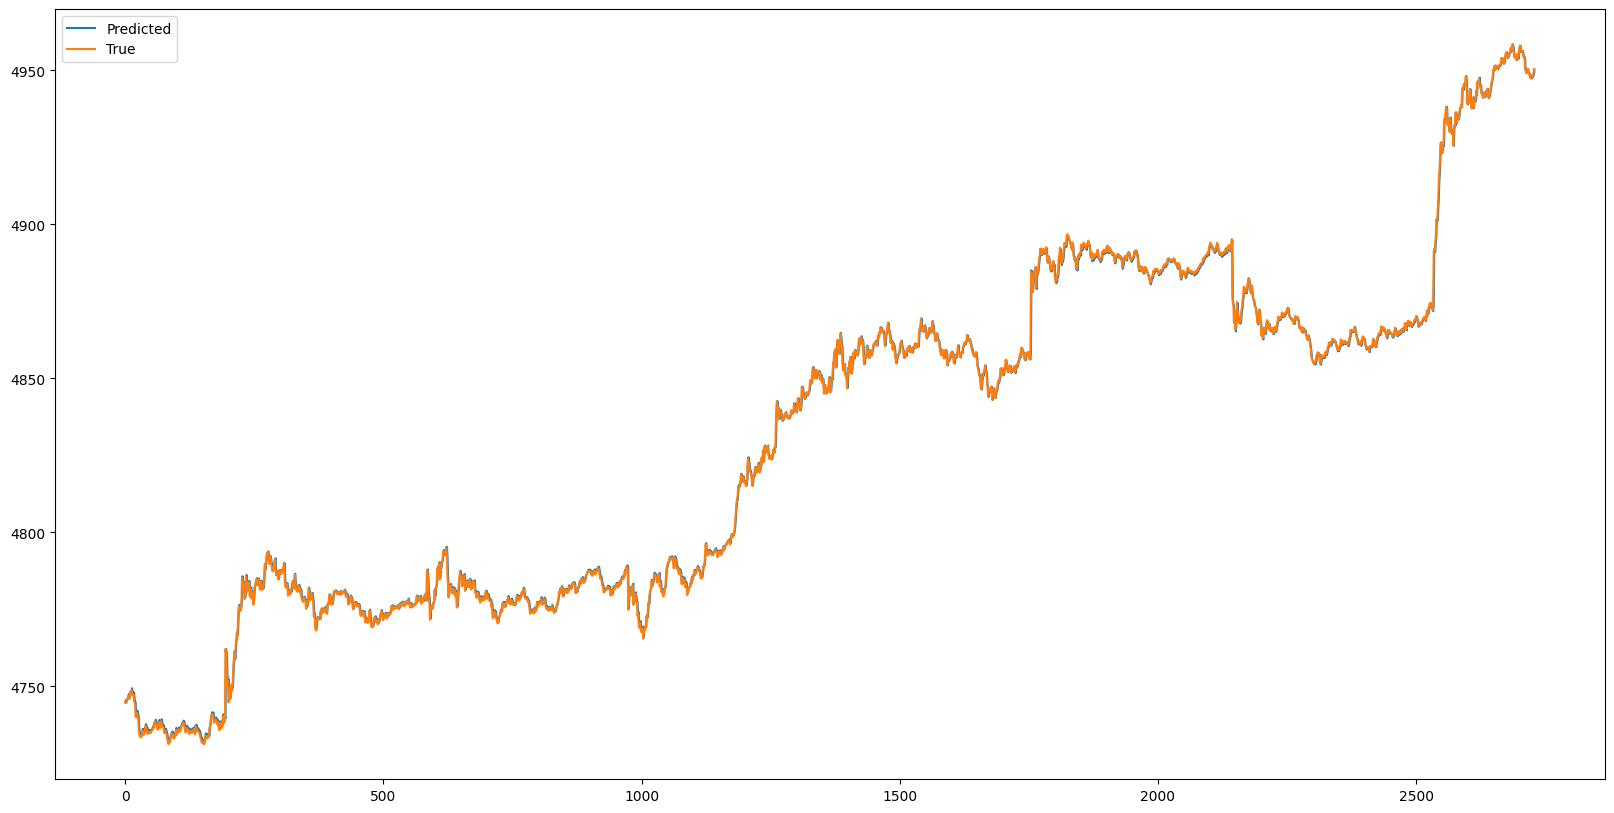

Epoch:  41 Train Loss:  0.006951950982811513 Val Loss:  0.007800962714780515
Epoch:  42 Train Loss:  0.0069550314423529125 Val Loss:  0.009191835380243983
Epoch:  43 Train Loss:  0.006988483160859822 Val Loss:  0.006394022367439792
Epoch:  44 Train Loss:  0.007101775159496467 Val Loss:  0.007894054371280872
Epoch:  45 Train Loss:  0.007086405559418104 Val Loss:  0.008976203526163474
Epoch:  46 Train Loss:  0.0070486480961399626 Val Loss:  0.006251009481187012
Epoch:  47 Train Loss:  0.006948698482146106 Val Loss:  0.007620062527376229
Epoch:  48 Train Loss:  0.006839302766219147 Val Loss:  0.006260945407621182
Epoch:  49 Train Loss:  0.00720213756894791 Val Loss:  0.006889429854995132
Epoch:  50 Train Loss:  0.007052846697877989 Val Loss:  0.006643578760186251
MSE:  3.0377705 MAE:  1.1602439


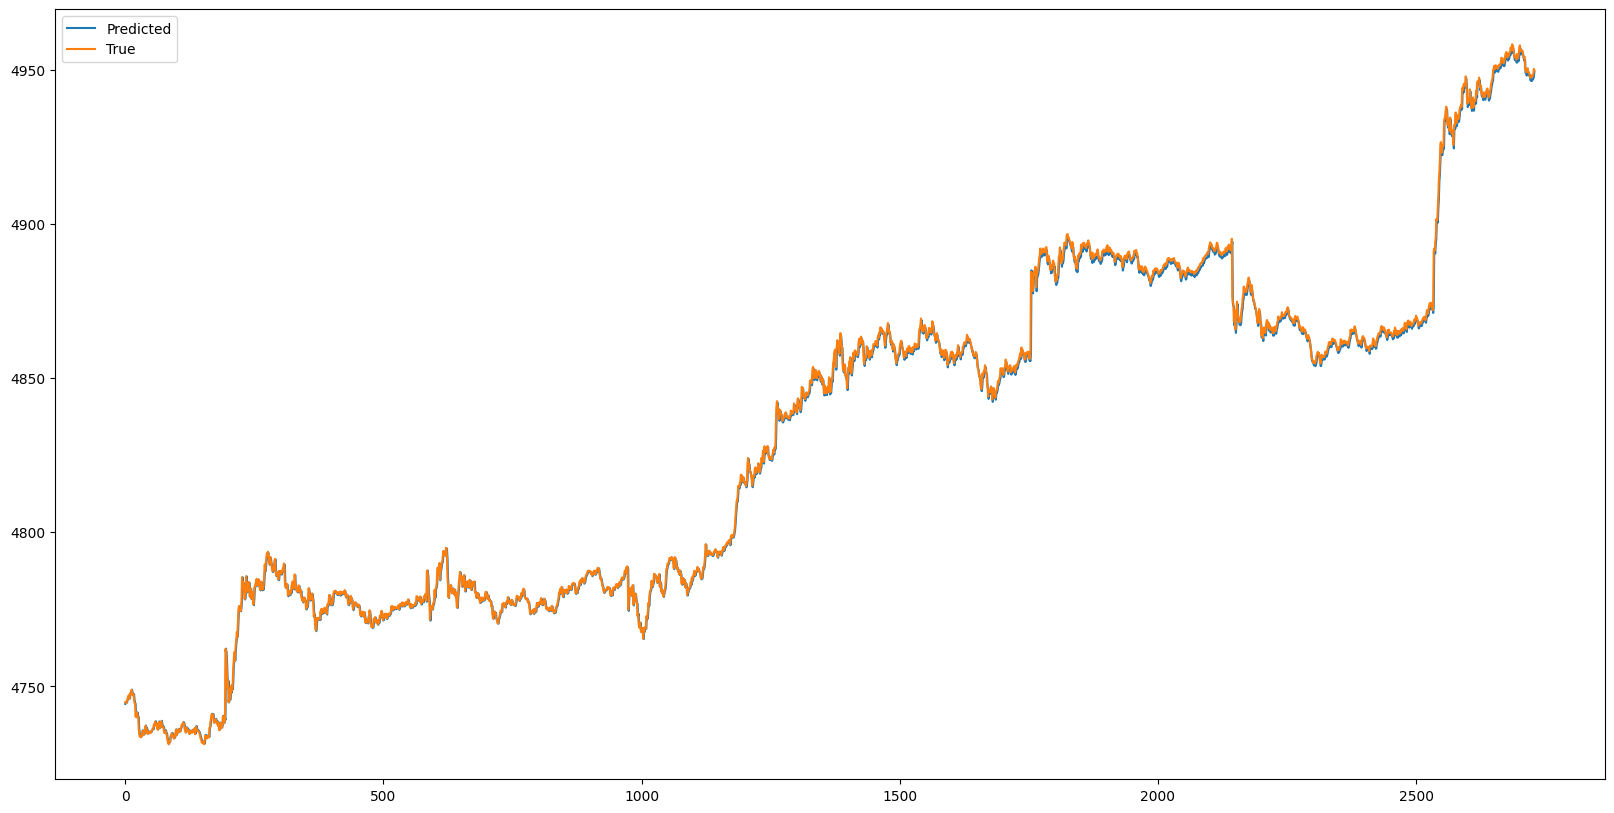

Epoch:  51 Train Loss:  0.006936865799748983 Val Loss:  0.007365904036007635
Epoch:  52 Train Loss:  0.0069572447291362405 Val Loss:  0.006867475234159726
Epoch:  53 Train Loss:  0.007161388566367539 Val Loss:  0.007173601906017016
Epoch:  54 Train Loss:  0.007113767668847196 Val Loss:  0.00624267956489857


In [40]:
for epoch in range(epochs):
    mse_train = 0
    for batch_x, batch_y_h, batch_y in data_train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_x, batch_y_h).squeeze(1)
        loss_value = loss_function(y_pred, batch_y)
        loss_value.backward()
        optimizer.step()
        mse_train += loss_value.item() * batch_x.shape[0]

    scheduler.step()

    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_val_loader:
            output = model(batch_x, batch_y_h).squeeze(1)
            preds.append(output.detach().numpy())
            true.append(batch_y.detach().numpy())
            mse_val += loss_function(output, batch_y).item() * batch_x.shape[0]

        preds = np.concatenate(preds)
        true = np.concatenate(true)

        if min_val_loss > mse_val**0.5:
            min_val_loss = mse_val**0.5
            print("Saving model...")
            torch.save(model.state_dict(), "darnn_nasdaq.pt")
            counter = 0
        else:
            counter += 1

        if counter == patience:
            break

        print("Epoch: ", epoch, "Train Loss: ", (mse_train / len(X_train_t))**0.5, "Val Loss: ", (mse_val / len(X_val_t))**0.5)

        if epoch % 10 == 0:
            preds = preds * (target_train_max - target_train_min) + target_train_min
            true = true * (target_train_max - target_train_min) + target_train_min
            mse = mean_squared_error(true, preds)
            mae = mean_absolute_error(true, preds)
            print("MSE: ", mse, "MAE: ", mae)
            plt.figure(figsize=(20, 10))
            plt.plot(preds, label='Predicted')
            plt.plot(true, label='True')
            plt.legend()
            plt.show()

In [41]:
# Load the best model
model.load_state_dict(torch.load("darnn_nasdaq.pt"))

<All keys matched successfully>

In [42]:
# Evaluate on the test set
with torch.no_grad():
    mse_test = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in data_test_loader:
        output = model(batch_x, batch_y_h).squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_test += loss_function(output, batch_y).item() * batch_x.shape[0]

preds = np.concatenate(preds)
true = np.concatenate(true)

In [43]:
preds = preds * (target_train_max - target_train_min) + target_train_min
true = true * (target_train_max - target_train_min) + target_train_min

In [44]:
# Display evaluation metrics
mse_test, mae_test = mean_squared_error(true, preds), mean_absolute_error(true, preds)
print("Test MSE:", mse_test, "Test MAE:", mae_test)

Test MSE: 2.1986306 Test MAE: 1.0078436


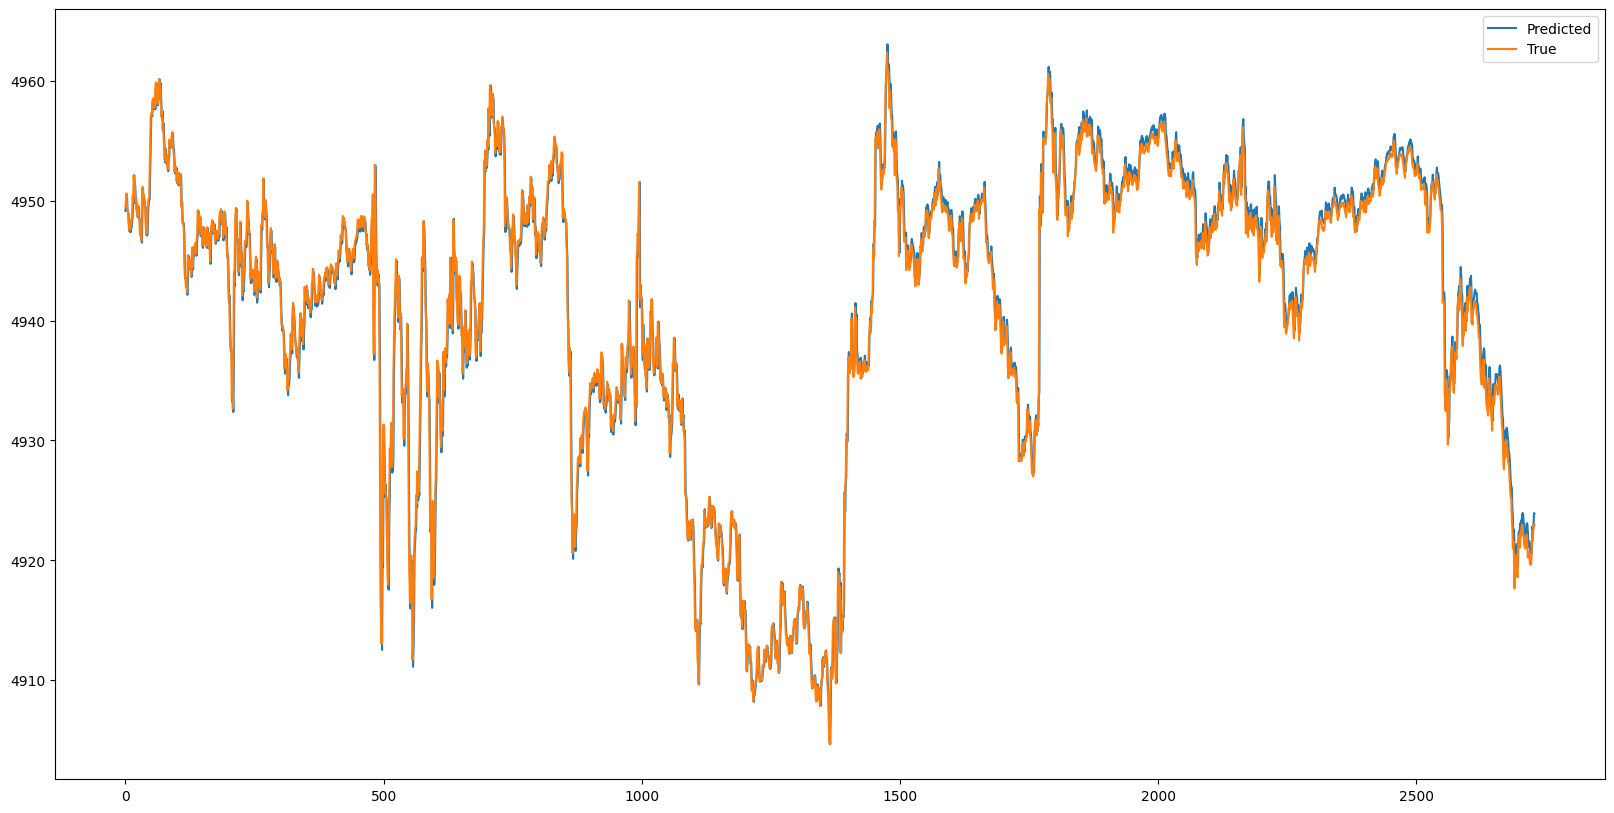

In [45]:
# Plot predictions vs true values
plt.figure(figsize=(20, 10))
plt.plot(preds, label='Predicted')
plt.plot(true, label='True')
plt.legend()
plt.show()